# Autonomous Driving (Part 3)

In this assignment, the goal is to try different configurations for the assignment Autonomous Driving (Part 2).


for learning to drive autonomously. For that reason, We will use the car racing example from [Gym](http://gym.openai.com). As we show in the last assignment, Gym is a framework for developing reinforcement learning approaches. It supports different types of agents. Here, we will focus on vehicles.

*Important*: You need to install [Gym](http://gym.openai.com) in your system. The installation can be done with pip or by installing from the sources. More information at [https://gym.openai.com/docs/#installation](https://gym.openai.com/docs/#installation).

*Important*: The Python version of Gym and the Python version of PyTorch has to be the same. This is an important requirement for making the inference pipeline function.

Note that all scripts should be self-contained and executed on *any* machine that has required libraries installed.



## 1. Model Preparation

In this exercise, the trained model from the last assignment is necessary for performing different tests. The setups is the same where the car can turn left, right, accelerate or decelerate. The input is an image with 96x96 pixels. The test set is the same from Assignment 3, i.e. 1000 test consecutive frames. The 1000 test samples also include a maneuver.
 
*Task Output*: Consider a model that is trained without data augmentation from Assignment 3. Test the model on 1000 consecutive test frames, each with a different scenario: 1. upside-down frame flip, 2. left-right frame flip and brown street color. You should generate three different videos (mp4) for each test scenario. We recommend the library _cv2_ to generate the videos. On the first case all 1000 frames should flipped upside-down, on the second case all 1000 frames should flipped left-right and final on the last case the road should be painted brown for all 1000 frames. The deliverable of the exercise are the average test accuracy per scenario plus three videos highlighting driving the car in each test scenario.

*Important*: The scripts should be **self-contained**.

In [3]:
#generate videos
import sys
print(sys.executable)

%run car_racing.py

c:\Users\pgudi\.conda\envs\MLSP_Lab\python.exe
c:\Users\pgudi\.conda\envs\MLSP_Lab\python.exe
Loading existing data from all_episodes_1000Frames_3.npz...
Loaded 1001 frames and 1001 actions.

action 0
step 0 total_reward +6.97
Saved 1002 frames and 1002 actions to all_episodes_1000Frames_3.npz.
Video saved to car_racing_1000frames_3.mp4.
Exiting.


In [4]:
#define network architecture used as before

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define CNN model for 96x96 images and 5 class o/p
class CarCNN(nn.Module):
    def __init__(self):
        super(CarCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2),  # 96x96 → 48x48
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),  # 48x48 → 24x24
            nn.ReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),  # 24x24 → 12x12
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 5)  # 5 classes
        )

    def forward(self, x):
        return self.net(x)

Using device: cuda


In [2]:
#case1: calculate the accuracy of the model trained without augmentation and upside down frame flipping

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
from torchvision import transforms
from PIL import Image

class CarRacingDataset(Dataset):
    def __init__(self, npz_file, augmentations=True, horizontal_flip=False, vertical_flip=False, street_color_change=False):
        """
        Args:
            npz_file (str): Path to the .npz file containing 'frames' and 'actions'.
            augmentations (bool): Whether to apply augmentations.
            horizontal_flip (bool): Whether to apply horizontal flip.
            vertical_flip (bool): Whether to apply vertical flip.
            street_color_change (bool): Whether to apply street color change.
        """
        data = np.load(npz_file)
        self.frames = data['frames']
        self.actions = data['actions']
        self.augmentations = augmentations
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.street_color_change = street_color_change
        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.frames)

    def _apply_horizontal_flip(self, image):
        if self.horizontal_flip and self.augmentations:
            return image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def _apply_vertical_flip(self, image):
        if self.vertical_flip and self.augmentations:
            return image.transpose(Image.FLIP_TOP_BOTTOM)
        return image

    def _apply_street_color_change(self, image):
        if self.street_color_change and self.augmentations:
            # Define the gray and brown color ranges
            gray_min = [100, 100, 100]
            gray_max = [150, 150, 150]
            brown_min = [90, 60, 30]
            brown_max = [150, 100, 60]

            img_np = np.array(image)
            mask = np.all((img_np >= gray_min) & (img_np <= gray_max), axis=2)
            # Generate a random brown color for each channel independently
            brown_color = np.array([random.randint(brown_min[i], brown_max[i]) for i in range(3)], dtype=np.uint8)
            img_np[mask] = brown_color
            return Image.fromarray(img_np)
        return image

    def __getitem__(self, idx):
        frame = self.frames[idx]
        action = self.actions[idx]

        image = self.to_pil(frame)

        image = self._apply_horizontal_flip(image)
        image = self._apply_vertical_flip(image)
        image = self._apply_street_color_change(image)

        image = self.to_tensor(image)
        action = torch.tensor(action, dtype=torch.float32)

        return image, action

if __name__ == '__main__':
    # Assuming you have an 'all_episodes.npz' file in the same directory
    npz_file_path = 'all_episodes_1000Frames_1.npz'

    # create the Dataset
    dataset = CarRacingDataset(
        npz_file=npz_file_path,
        augmentations=True, #making augmentations to false here renders the other parameters useless
        horizontal_flip=False,
        vertical_flip=True,
        street_color_change=False
    )

    print(f"Test size: {len(dataset)}")

    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    for images, actions in dataloader:
        print(f"Batch size: {images.size(0)}")
        print(f"Image shape: {images.shape}")
        print(f"Actions shape: {actions.shape}")
        break  # Just to check the first batch

    # Load model
    model_path = "driving_model.pth"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CarCNN()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Accuracy calculation
    correct = 0
    total = 0

    with torch.no_grad():
        for images, actions in dataloader:
            images = images.to(device)
            actions = actions.to(device).long()  # Ensure proper type for comparison
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == actions).sum().item()
            total += actions.size(0)

    accuracy = correct / total
    print(f"\nModel accuracy on test set with vertical flip: {accuracy * 100:.2f}%")



Test size: 1000
Batch size: 32
Image shape: torch.Size([32, 3, 96, 96])
Actions shape: torch.Size([32])


NameError: name 'CarCNN' is not defined

In [6]:
#case2: calculate the accuracy of the model trained without augmentation horizontal flipping

# Assuming you have an 'all_episodes.npz' file in the same directory
npz_file_path = 'all_episodes_1000Frames_2.npz'

# create the Dataset
dataset = CarRacingDataset(
    npz_file=npz_file_path,
    augmentations=True, #making augmentations to false here renders the other parameters useless
    horizontal_flip=True,
    vertical_flip=False,
    street_color_change=False
)

print(f"Test size: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
for images, actions in dataloader:
    print(f"Batch size: {images.size(0)}")
    print(f"Image shape: {images.shape}")
    print(f"Actions shape: {actions.shape}")
    break  # Just to check the first batch

# Load model
model_path = "driving_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CarCNN()
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Accuracy calculation
correct = 0
total = 0

with torch.no_grad():
    for images, actions in dataloader:
        images = images.to(device)
        actions = actions.to(device).long()  # Ensure proper type for comparison
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == actions).sum().item()
        total += actions.size(0)

accuracy = correct / total
print(f"\nModel accuracy on test set with Horizontal flip: {accuracy * 100:.2f}%")

Test size: 1000
Batch size: 32
Image shape: torch.Size([32, 3, 96, 96])
Actions shape: torch.Size([32])


C:\Users\pgudi\AppData\Local\Temp\ipykernel_9248\1717682948.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


Model accuracy on test set with Horizontal flip: 64.30%


In [7]:
#case3: calculate the accuracy of the model trained without augmentation horizontal flipping

# Assuming you have an 'all_episodes.npz' file in the same directory
npz_file_path = 'all_episodes_1000Frames_2.npz'

# create the Dataset
dataset = CarRacingDataset(
    npz_file=npz_file_path,
    augmentations=True, #making augmentations to false here renders the other parameters useless
    horizontal_flip=False,
    vertical_flip=False,
    street_color_change=True
)

print(f"Test size: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
for images, actions in dataloader:
    print(f"Batch size: {images.size(0)}")
    print(f"Image shape: {images.shape}")
    print(f"Actions shape: {actions.shape}")
    break  # Just to check the first batch

# Load model
model_path = "driving_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CarCNN()
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Accuracy calculation
correct = 0
total = 0

with torch.no_grad():
    for images, actions in dataloader:
        images = images.to(device)
        actions = actions.to(device).long()  # Ensure proper type for comparison
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == actions).sum().item()
        total += actions.size(0)

accuracy = correct / total
print(f"\nModel accuracy on test set with brown road: {accuracy * 100:.2f}%")

Test size: 1000
Batch size: 32
Image shape: torch.Size([32, 3, 96, 96])
Actions shape: torch.Size([32])


C:\Users\pgudi\AppData\Local\Temp\ipykernel_9248\2793114370.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de


Model accuracy on test set with brown road: 86.20%


## 2. Autonomous Driving

In this exercise, the trained model from the last assignment is necessary for end-to-end driving. The goal is to use the neural network to drive the car whitin the simulator. For the reason, both programs have to executed under the same python script. The simulator will provide with input data the neural network, while the neural network will provide the action to the simulator. Note: if the neural network is not able to drive in the simulator, you might need to retrain the model with more data.
 
*Task Output*: Consider a model that is trained with the data augmentation from Assignment 3. Integrate the simulator in the inference script of the model. The output of the exercise is to launch the simulator and let the neural network perform the driving. This should be a live demo.

*Important*: The scripts should be **self-contained**.

C:\Users\pgudi\AppData\Local\Temp\ipykernel_16816\2851441833.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

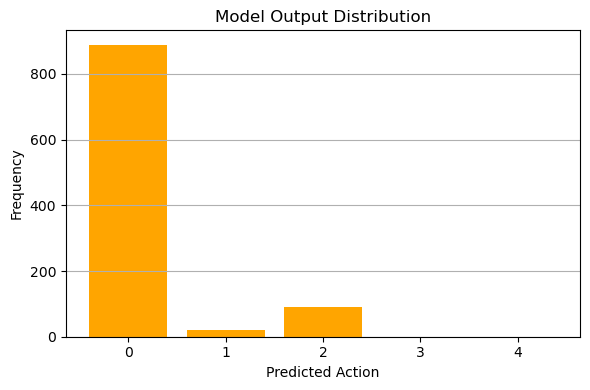

In [10]:
# plot the model output distribution
import matplotlib.pyplot as plt
import numpy as np

predictions = []

# Assuming you have an 'all_episodes.npz' file in the same directory
npz_file_path = 'all_episodes_1000Frames_2.npz'

# create the Dataset
dataset = CarRacingDataset(
    npz_file=npz_file_path,
    augmentations=True, #making augmentations to false here renders the other parameters useless
    horizontal_flip=False,
    vertical_flip=False,
    street_color_change=True
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load model
model_path = "driving_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CarCNN()
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

model.eval()
with torch.no_grad():
    for images, _ in dataloader:
        images = images.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(predicted)

# Plot histogram of model predictions
plt.figure(figsize=(6,4))
plt.hist(predictions, bins=np.arange(6)-0.5, rwidth=0.8, align='mid', color='orange')
plt.xticks(range(5))
plt.xlabel("Predicted Action")
plt.ylabel("Frequency")
plt.title("Model Output Distribution")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [11]:
#generate videos
import sys
print(sys.executable)

%run car_racing_AIDrive.py

c:\Users\pgudi\.conda\envs\MLSP_Lab\python.exe
c:\Users\pgudi\.conda\envs\MLSP_Lab\python.exe
Using device: cuda


C:\Users\pgudi\Documents\FAU\AssignmentsTutorials\Sem3\MLSP_Lab\Assignment4\car_racing_AIDrive.py:816: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

Predicted action: steer=0.02, gas=0.00, brake=0.00

Step 0 | Total reward: 6.50
Predicted action: steer=0.06, gas=0.00, brake=0.00
Predicted action: steer=0.69, gas=0.00, brake=0.00
Predicted action: steer=0.97, gas=0.00, brake=0.00
Predicted action: steer=0.99, gas=0.00, brake=0.00
Predicted action: steer=0.98, gas=0.00, brake=0.00
Predicted action: steer=0.95, gas=0.00, brake=0.00
Predicted action: steer=0.94, gas=0.00, brake=0.00
Predicted action: steer=0.98, gas=0.01, brake=0.00
Predicted action: steer=0.98, gas=0.07, brake=0.00
Predicted action: steer=0.98, gas=0.08, brake=0.00
Predicted action: steer=0.97, gas=0.10, brake=0.00
Predicted action: steer=0.97, gas=0.11, brake=0.00
Predicted action: steer=0.97, gas=0.12, brake=0.00
Predicted action: steer=0.97, gas=0.11, brake=0.01
Predicted action: steer=0.98, gas=0.11, brake=0.01
Predicted action: steer=0.98, gas=0.11, brake=0.01
Predicted action: steer=0.98, gas=0.12, brake=0.01
Predicted action: steer=0.98, gas=0.13, brake=0.01
Pr

KeyboardInterrupt: 

## 3. Recurrent Neural Network Model

In this task, the goal is to change one of more hidden layers of the MLP with a recurrent layer such as [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#lstm) or [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU). Instead of training a model that predicts the action independently from other images, we will train a model that keeps a state through the input frames. As a result, the proposed model action depends not only on the input frame but also on the past ones

 
*Task Output*: The feed forward network should be replaced with a recurrent neural network (RNN). The number of cells can be freely chosen. Once the RNN is trained, it should be used for end-to-end driving as in the previous exercise. The output of the exercise is to launch the simulator and let the RNN perform the driving. This should be a live demo as well.

*Important*: The scripts should be **self-contained**.

In [ ]:
#colect the dataset
import sys
print(sys.executable)

''' our code uses continuous action space by default
### Action Space
    If continuous:
        There are 3 actions: steering (-1 is full left, +1 is full right), gas, and breaking.
        these actions are stored along with the frame numbers in an excel file.
'''

%run car_racing_RNN_gen.py

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
from torchvision import transforms
from PIL import Image

class CarRacingEpisodeDataset(Dataset):
    def __init__(self, npz_path, sequence_length=10,
                 augmentations=True, horizontal_flip=True,
                 random_rotation=True, vertical_flip=False,
                 street_color_change=False):
        data = np.load(npz_path, allow_pickle=True)
        raw_episodes = data["episodes"]

        # Unpack all episodes into frame-action pairs with episode index
        self.sequences = []  # Each entry: (episode_idx, start_idx)
        self.episodes = []

        for episode_idx, (frames, actions) in enumerate(raw_episodes):
            frames = np.array(frames)
            actions = np.array(actions)
            self.episodes.append((frames, actions))
            if len(frames) >= sequence_length:
                for i in range(len(frames) - sequence_length + 1):
                    self.sequences.append((episode_idx, i))

        self.sequence_length = sequence_length
        self.augmentations = augmentations
        self.horizontal_flip = horizontal_flip
        self.random_rotation = random_rotation
        self.vertical_flip = vertical_flip
        self.street_color_change = street_color_change

        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.sequences)

    def _apply_horizontal_flip(self, image, action):
        if random.random() < 0.2 and self.horizontal_flip and self.augmentations:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            action[0] = -action[0]  # flip steering
        return image, action

    def _apply_random_rotation(self, image):
        if random.random() < 0.2 and self.random_rotation and self.augmentations:
            angle = random.uniform(-20, 20)
            return image.rotate(angle)
        return image

    def _apply_vertical_flip(self, image):
        if random.random() < 0.2 and self.vertical_flip and self.augmentations:
            return image.transpose(Image.FLIP_TOP_BOTTOM)
        return image

    def _apply_street_color_change(self, image):
        if random.random() < 0.2 and self.street_color_change and self.augmentations:
            gray_min = np.array([100, 100, 100])
            gray_max = np.array([150, 150, 150])
            brown_min = np.array([90, 60, 30])
            brown_max = np.array([150, 100, 60])
            img_np = np.array(image)
            mask = np.all((img_np >= gray_min) & (img_np <= gray_max), axis=2)
            brown_color = np.array([random.randint(brown_min[i], brown_max[i]) for i in range(3)], dtype=np.uint8)
            img_np[mask] = brown_color
            return Image.fromarray(img_np)
        return image

    def __getitem__(self, idx):
        episode_idx, start_idx = self.sequences[idx]
        frames, actions = self.episodes[episode_idx]
        frames_seq = []
        actions_seq = []

        for i in range(self.sequence_length):
            frame = frames[start_idx + i]
            action = actions[start_idx + i].copy()

            image = self.to_pil(frame)
            image, action = self._apply_horizontal_flip(image, action)
            image = self._apply_random_rotation(image)
            image = self._apply_vertical_flip(image)
            image = self._apply_street_color_change(image)

            image = self.to_tensor(image)
            frames_seq.append(image)
            actions_seq.append(torch.tensor(action, dtype=torch.float32))

        return torch.stack(frames_seq), torch.stack(actions_seq)  # [T, C, H, W], [T, 3]


In [7]:
# Define CNN + RNN model for 96x96 images and 5 class o/p

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import numpy as np

class CarCNN_RNN(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1):
        super(CarCNN_RNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2),  # 96x96 -> 48x48
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),  # 48x48 -> 24x24
            nn.ReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),  # 24x24 -> 12x12
            nn.ReLU()
        )
        self.feature_size = 128 * 12 * 12
        self.rnn = nn.GRU(self.feature_size, hidden_size, num_layers, batch_first=True)
        # Output: [steer, gas, brake]
        # It's often better to have separate heads for different action types
        self.fc_steer = nn.Linear(hidden_size, 1)
        self.fc_gas = nn.Linear(hidden_size, 1)
        self.fc_brake = nn.Linear(hidden_size, 1)

    def forward(self, x):
        B, T, C, H, W = x.size()
        cnn_features = []
        for t in range(T):
            out = self.cnn(x[:, t])  # [B, 128, 12, 12]
            out = out.reshape(B, -1) # [B, 18432]
            cnn_features.append(out)
        cnn_features = torch.stack(cnn_features, dim=1)  # [B, T, feature_size]
        rnn_out, _ = self.rnn(cnn_features)              # [B, T, hidden_size]

        # Apply activations per action type
        steer = torch.tanh(self.fc_steer(rnn_out))  # [-1, 1]
        gas = torch.sigmoid(self.fc_gas(rnn_out))    # [0, 1]
        brake = torch.sigmoid(self.fc_brake(rnn_out)) # [0, 1]

        # Concatenate outputs
        out = torch.cat((steer, gas, brake), dim=-1) # [B, T, 3]
        return out


Using device: cuda
Component weights: tensor([ 0.1000, 10.0000,  1.0000], device='cuda:0')
Epoch 1: Train Loss=0.5082, Val Loss=0.2604
🔸 Saved best model.
Epoch 2: Train Loss=0.2080, Val Loss=0.1653
🔸 Saved best model.
Epoch 3: Train Loss=0.1876, Val Loss=0.1612
🔸 Saved best model.
Epoch 4: Train Loss=0.1829, Val Loss=0.1498
🔸 Saved best model.
Epoch 5: Train Loss=0.1688, Val Loss=0.1490
🔸 Saved best model.
Epoch 6: Train Loss=0.1693, Val Loss=0.1454
🔸 Saved best model.
Epoch 7: Train Loss=0.1846, Val Loss=0.1633
Epoch 8: Train Loss=0.1668, Val Loss=0.1478
Epoch 9: Train Loss=0.1645, Val Loss=0.1456
⛔ Early stopping triggered.


C:\Users\pgudi\AppData\Local\Temp\ipykernel_20420\3708313157.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unfiltered_IP_cnn_rnn_bes

✅ Test Loss: 0.1885


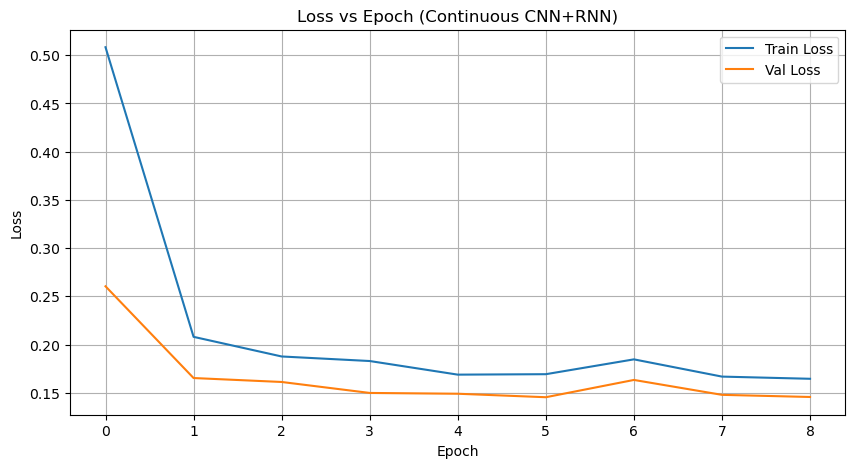

In [9]:
#train the CNN+RNN model

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import numpy as np
import os
import gc

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
npz_file_path = 'Unfiltered_IP_CNN_RNN_continuous_15k_dataset.npz'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

dataset = CarRacingEpisodeDataset(npz_path=npz_file_path)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
test_dataset = Subset(dataset, range(train_size + val_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

# Weights for [steer, gas, brake]
component_weights = torch.tensor([0.1,10.0,1.0]).to(device) #[steer, gas,brake]

print("Component weights:", component_weights)
criterion = nn.MSELoss(reduction='none')
# criterion = nn.MSELoss()

model = CarCNN_RNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping Setup
patience = 3
min_delta = 0
best_val_loss = float('inf')
patience_counter = 0

# Tracking
num_epochs = 50
train_losses, val_losses, test_losses = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # [B, T, C, H, W], [B, T, 3]
        optimizer.zero_grad()
        outputs = model(images)  # [B, T, 3]

        loss_per_sample = criterion(outputs, labels)        # [B, T, 3]
        weighted_loss = loss_per_sample * component_weights # [B, T, 3]
        loss = weighted_loss.mean()
        # loss = criterion(outputs, labels)  # no weighting, just plain MSE loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_per_sample = criterion(outputs, labels)
            weighted_loss = loss_per_sample * component_weights
            loss = weighted_loss.mean()
            # loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "unfiltered_IP_cnn_rnn_best_continuous.pth")
        print("🔸 Saved best model.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# Test
model.load_state_dict(torch.load("unfiltered_IP_cnn_rnn_best_continuous.pth"))
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss_per_sample = criterion(outputs, labels)
        weighted_loss = loss_per_sample * component_weights
        loss = weighted_loss.mean()
        # loss = criterion(outputs, labels)
        test_loss += loss.item()
test_loss /= len(test_loader)
test_losses.append(test_loss)
print(f"✅ Test Loss: {test_loss:.4f}")

# Save final model
torch.save(model.state_dict(), "unfiltered_IP_cnn_rnn_final_continuous.pth")
gc.collect()
torch.cuda.empty_cache()

# Plots
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss vs Epoch (Continuous CNN+RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [17]:
#run the GRUDrive script to run the car racing environment with the trained model
import sys
print(sys.executable)

%run car_racing_GRUDrive.py

c:\Users\pgudi\.conda\envs\MLSP_Lab\python.exe
c:\Users\pgudi\.conda\envs\MLSP_Lab\python.exe
Using device: cuda


C:\Users\pgudi\Documents\FAU\AssignmentsTutorials\Sem3\MLSP_Lab\Assignment4\car_racing_GRUDrive.py:913: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

Predicted action: steer=0.66, gas=0.25, brake=0.02

Step: 0 | Total reward: 6.82
Predicted action: steer=0.88, gas=0.22, brake=0.02
Predicted action: steer=0.93, gas=0.21, brake=0.02
Predicted action: steer=0.94, gas=0.21, brake=0.02
Predicted action: steer=0.92, gas=0.21, brake=0.02
Predicted action: steer=0.90, gas=0.01, brake=0.02
Predicted action: steer=0.87, gas=0.01, brake=0.02
Predicted action: steer=0.78, gas=0.01, brake=0.02
Predicted action: steer=0.64, gas=0.01, brake=0.02
Predicted action: steer=0.56, gas=0.01, brake=0.02
Predicted action: steer=0.63, gas=0.01, brake=0.02
Predicted action: steer=0.65, gas=0.01, brake=0.02
Predicted action: steer=0.69, gas=0.01, brake=0.02
Predicted action: steer=0.68, gas=0.01, brake=0.02
Predicted action: steer=0.66, gas=0.01, brake=0.02
Predicted action: steer=0.65, gas=0.01, brake=0.02
Predicted action: steer=0.64, gas=0.01, brake=0.02
Predicted action: steer=0.65, gas=0.01, brake=0.02
Predicted action: steer=0.65, gas=0.01, brake=0.02
P

KeyboardInterrupt: 

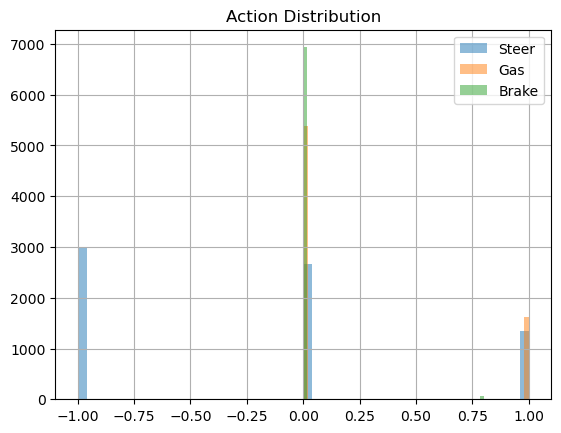

: 

In [ ]:
import matplotlib.pyplot as plt

actions = np.concatenate([actions for _, actions in dataset.episodes], axis=0)
steer = actions[:, 0]
gas = actions[:, 1]
brake = actions[:, 2]

plt.hist(steer, bins=50, alpha=0.5, label='Steer')
plt.hist(gas, bins=50, alpha=0.5, label='Gas')
plt.hist(brake, bins=50, alpha=0.5, label='Brake')
plt.legend(); plt.grid(); plt.title('Action Distribution'); plt.show()